In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import os

In [43]:
data_path = Path("data")
image_path = data_path / "CIFAR10"
train_data = torchvision.datasets.CIFAR10(root=image_path,
                                         train=True,
                                         download=True,
                                         transform=transforms.ToTensor())
test_data = torchvision.datasets.CIFAR10(root=image_path,
                                         train=False,
                                         download=True,
                                        transform=transforms.ToTensor())
print(train_data, test_data)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data\CIFAR10
    Split: Train
    StandardTransform
Transform: ToTensor() Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data\CIFAR10
    Split: Test
    StandardTransform
Transform: ToTensor()


In [44]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)
print(train_dataloader, test_dataloader)
print(f"Train dataloader lenght: {len(train_dataloader)}\nTest dataloader lenght: {len(test_dataloader)}")

<torch.utils.data.dataloader.DataLoader object at 0x000002225382BFD0> <torch.utils.data.dataloader.DataLoader object at 0x0000022242902050>
Train dataloader lenght: 1563
Test dataloader lenght: 313


In [45]:
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape

torch.Size([32, 3, 32, 32])

In [46]:
train_data.classes, image_batch.dtype

(['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 torch.float32)

In [4]:
class TinyVGG(nn.Module):
    def __init__(self, input_size: int, hidden_units: int, output_size: int):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(nn.Conv2d(in_channels=input_size,
                                                    out_channels=hidden_units,
                                                    kernel_size=3,
                                                    padding=0,
                                                    stride=1),
                                          nn.ReLU(),
                                          nn.Conv2d(in_channels=hidden_units,
                                                    out_channels=hidden_units,
                                                    kernel_size=3,
                                                    padding=0,
                                                    stride=1),
                                          nn.ReLU(),
                                          nn.MaxPool2d(kernel_size=2,
                                                       stride=1))
        self.conv_layer_2 = nn.Sequential(nn.Conv2d(in_channels=hidden_units,
                                                    out_channels=hidden_units,
                                                    kernel_size=3,
                                                    padding=0,
                                                    stride=1),
                                          nn.ReLU(),
                                          nn.Conv2d(in_channels=hidden_units,
                                                    out_channels=hidden_units,
                                                    kernel_size=3,
                                                    padding=0,
                                                    stride=1),
                                          nn.ReLU(),
                                          nn.MaxPool2d(kernel_size=2,
                                                       stride=1))
        self.linear_layer = nn.Sequential(nn.Flatten(),
                                          nn.Linear(in_features=hidden_units*22*22,
                                                    out_features=output_size))
    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.linear_layer(x)
        return x

In [61]:
model1 = TinyVGG(input_size = 3, hidden_units = 10, output_size = len(train_data.classes))
model1

TinyVGG(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4840, out_features=10, bias=True)
  )
)

In [7]:
def random_predictions(model):
    fig = plt.figure(figsize=(10,10))
    rows, cols = 3,3
    for i in range(1,rows*cols+1):
        rand_int = torch.randint(0,len(test_data),size=[1]).item()
        rand_img, rand_lbl = test_data[rand_int]
        y_pred = model(rand_img.unsqueeze(dim=0)).argmax(dim=1)
        pred_class = test_data.classes[y_pred]
        rand_class = test_data.classes[rand_lbl]
        fig.add_subplot(rows,cols,i)
        plt.imshow(rand_img.permute(1,2,0))
        plt.title(f"Pred: {pred_class}, Actual: {rand_class}")
        plt.axis(False)

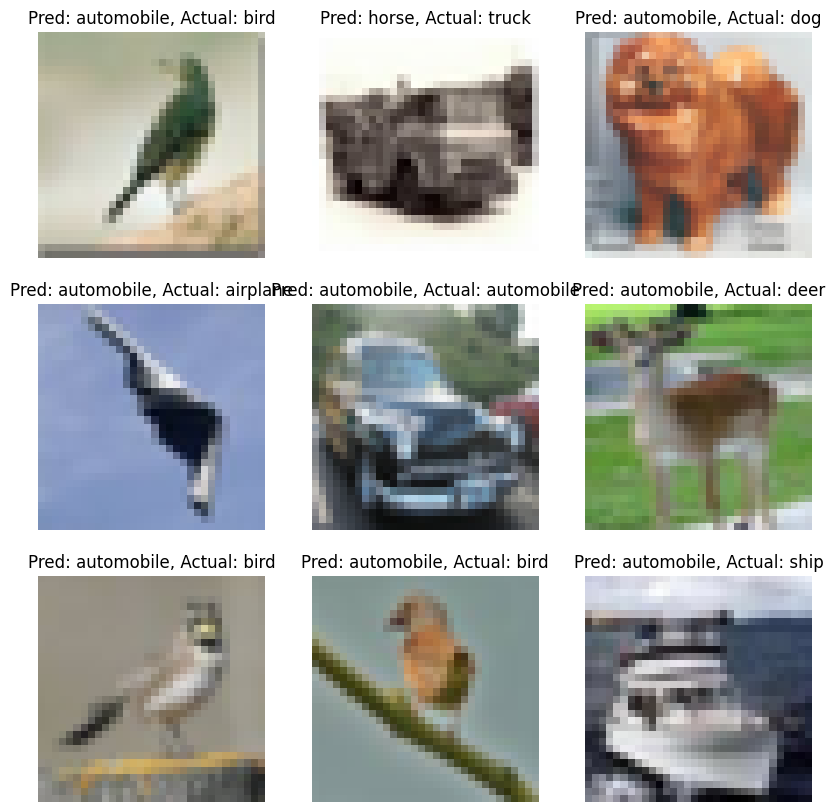

In [63]:
random_predictions(model1)

In [10]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [11]:
def train_pass(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer) -> torch.Tensor:
    model.train()
    train_loss = 0
    for batch,(X,y) in enumerate(dataloader):
        y_preds = model(X)
        loss = loss_fn(y_preds,y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss = train_loss/len(dataloader)
    return train_loss

In [12]:
def test_pass(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module) -> torch.Tensor:
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            y_pred = model(X)
            loss = loss_fn(y_pred,y)
            test_loss += loss
            test_acc += accuracy_fn(y,y_pred.argmax(dim=1))
    test_loss = test_loss/len(dataloader)
    test_acc = test_acc/len(dataloader)
    return test_loss, test_acc

In [13]:
def train_test_loop(model: torch.nn.Module,
                    train_dataloader: torch.utils.data.DataLoader,
                    test_dataloader: torch.utils.data.DataLoader,
                    epochs: int,
                    loss_fn: torch.nn.Module,
                    optimizer: torch.optim.Optimizer):
    for epoch in range(epochs):
        train_loss = train_pass(model, train_dataloader, loss_fn, optimizer)
        test_loss, test_acc = test_pass(model, test_dataloader, loss_fn)
        print(f"Epoch: {epoch+1}/{epochs}\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f} Test accuracy: {test_acc:.2f}%")

In [68]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model1.parameters(),lr=0.01)

In [71]:
train_test_loop(model1, train_dataloader, test_dataloader, 20, loss_fn, optimizer)

Epoch: 1/20
Train loss: 1.88985 | Test loss: 1.75783 Test accuracy: 37.29%
Epoch: 2/20
Train loss: 1.71962 | Test loss: 1.75584 Test accuracy: 37.49%
Epoch: 3/20
Train loss: 1.58423 | Test loss: 1.68813 Test accuracy: 41.12%
Epoch: 4/20
Train loss: 1.44126 | Test loss: 1.37851 Test accuracy: 50.84%
Epoch: 5/20
Train loss: 1.34124 | Test loss: 1.34198 Test accuracy: 52.95%
Epoch: 6/20
Train loss: 1.27097 | Test loss: 1.25103 Test accuracy: 56.14%
Epoch: 7/20
Train loss: 1.21232 | Test loss: 1.25291 Test accuracy: 55.51%
Epoch: 8/20
Train loss: 1.17430 | Test loss: 1.21248 Test accuracy: 57.66%
Epoch: 9/20
Train loss: 1.13879 | Test loss: 1.19857 Test accuracy: 58.03%
Epoch: 10/20
Train loss: 1.10440 | Test loss: 1.21368 Test accuracy: 57.60%
Epoch: 11/20
Train loss: 1.08276 | Test loss: 1.16554 Test accuracy: 59.30%
Epoch: 12/20
Train loss: 1.05936 | Test loss: 1.18264 Test accuracy: 58.86%
Epoch: 13/20
Train loss: 1.04100 | Test loss: 1.19559 Test accuracy: 57.93%
Epoch: 14/20
Train lo

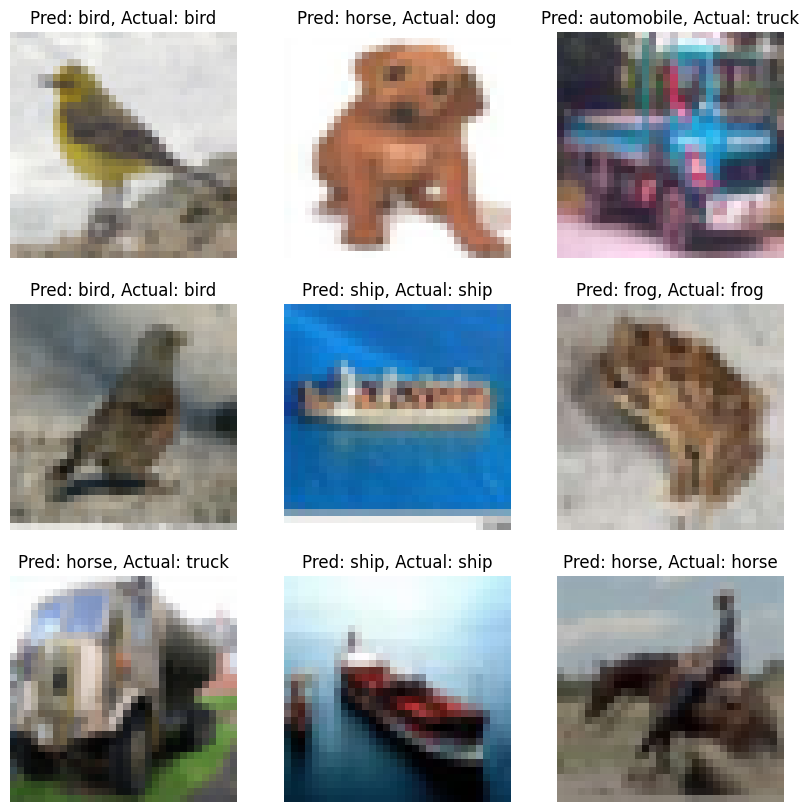

In [72]:
random_predictions(model1)

# Model with data augmentation

In [25]:
data_path = Path("data")
image_path = data_path / "CIFAR10"
image_transform = transforms.Compose([transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()])
train_data = torchvision.datasets.CIFAR10(root=image_path,
                                         train=True,
                                         download=True,
                                         transform=image_transform)
test_data = torchvision.datasets.CIFAR10(root=image_path,
                                         train=False,
                                         download=True,
                                        transform=transforms.ToTensor())
print(train_data, test_data)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data\CIFAR10
    Split: Train
    StandardTransform
Transform: Compose(
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           ) Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data\CIFAR10
    Split: Test
    StandardTransform
Transform: ToTensor()


In [26]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)
print(train_dataloader, test_dataloader)
print(f"Train dataloader lenght: {len(train_dataloader)}\nTest dataloader lenght: {len(test_dataloader)}")

<torch.utils.data.dataloader.DataLoader object at 0x000002E65FF3CEE0> <torch.utils.data.dataloader.DataLoader object at 0x000002E65FF3F5B0>
Train dataloader lenght: 1563
Test dataloader lenght: 313


In [27]:
model2 = TinyVGG(input_size = 3, hidden_units = 10, output_size = len(train_data.classes))
model2

TinyVGG(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4840, out_features=10, bias=True)
  )
)

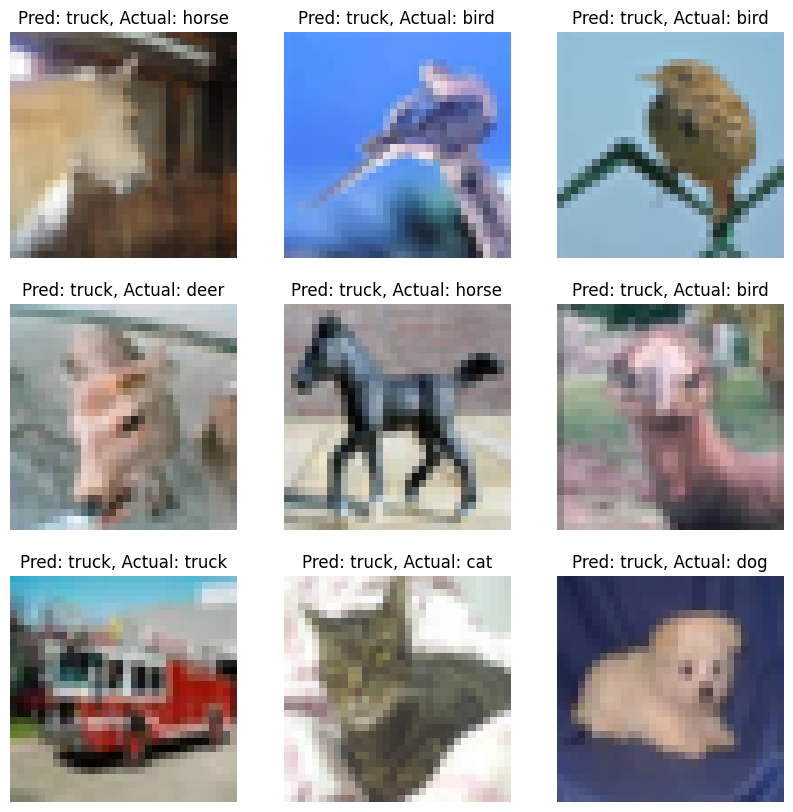

In [28]:
random_predictions(model2)

In [29]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model2.parameters(),lr=0.01)

In [30]:
train_test_loop(model2, train_dataloader, test_dataloader, 20, loss_fn, optimizer)

Epoch: 1/20
Train loss: 2.30161 | Test loss: 2.29035 Test accuracy: 17.60%
Epoch: 2/20
Train loss: 2.18546 | Test loss: 1.96516 Test accuracy: 28.09%
Epoch: 3/20
Train loss: 2.07378 | Test loss: 1.88771 Test accuracy: 32.01%
Epoch: 4/20
Train loss: 2.00049 | Test loss: 1.77059 Test accuracy: 36.68%
Epoch: 5/20
Train loss: 1.89496 | Test loss: 1.60534 Test accuracy: 43.14%
Epoch: 6/20
Train loss: 1.81244 | Test loss: 1.58113 Test accuracy: 42.13%
Epoch: 7/20
Train loss: 1.77335 | Test loss: 1.45048 Test accuracy: 48.52%
Epoch: 8/20
Train loss: 1.73985 | Test loss: 1.48237 Test accuracy: 47.38%
Epoch: 9/20
Train loss: 1.71709 | Test loss: 1.58521 Test accuracy: 42.95%
Epoch: 10/20
Train loss: 1.69433 | Test loss: 1.53283 Test accuracy: 46.33%
Epoch: 11/20
Train loss: 1.67514 | Test loss: 1.34907 Test accuracy: 53.73%
Epoch: 12/20
Train loss: 1.64978 | Test loss: 1.42807 Test accuracy: 49.65%
Epoch: 13/20
Train loss: 1.62701 | Test loss: 1.38116 Test accuracy: 50.68%
Epoch: 14/20
Train lo

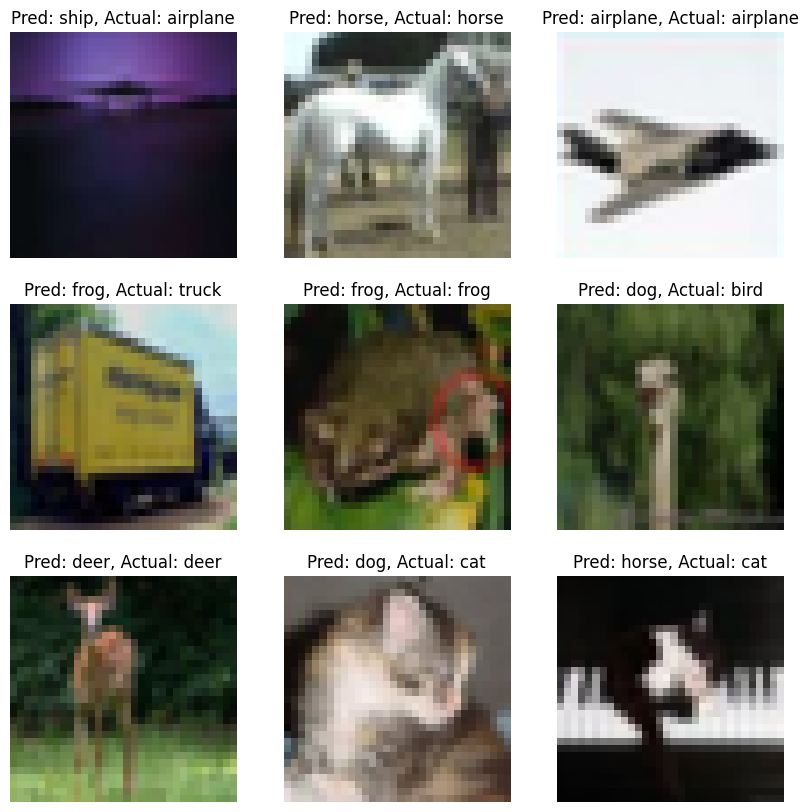

In [31]:
random_predictions(model2)

# Using Modified TinyVGG Model

In [52]:
class Modified_TinyVGG(nn.Module):
    def __init__(self, input_size: int, hidden_units: int, output_size: int):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(nn.Conv2d(in_channels=input_size,
                                                    out_channels=hidden_units,
                                                    kernel_size=3,
                                                    padding=0,
                                                    stride=1),
                                          nn.ReLU(),
                                          nn.Conv2d(in_channels=hidden_units,
                                                    out_channels=hidden_units,
                                                    kernel_size=3,
                                                    padding=0,
                                                    stride=1),
                                          nn.ReLU(),
                                          nn.MaxPool2d(kernel_size=2,
                                                       stride=1))
        self.conv_layer_2 = nn.Sequential(nn.Conv2d(in_channels=hidden_units,
                                                    out_channels=hidden_units,
                                                    kernel_size=3,
                                                    padding=0,
                                                    stride=1),
                                          nn.ReLU(),
                                          nn.Conv2d(in_channels=hidden_units,
                                                    out_channels=hidden_units,
                                                    kernel_size=3,
                                                    padding=0,
                                                    stride=1),
                                          nn.ReLU(),
                                          nn.MaxPool2d(kernel_size=2,
                                                       stride=1))
        self.linear_layer = nn.Sequential(nn.Flatten(),
                                          nn.Linear(in_features=hidden_units*22*22, out_features=2420),
                                         nn.ReLU(),
                                          nn.Linear(in_features=2420, out_features=605),
                                         nn.ReLU(),
                                          nn.Linear(in_features=605, out_features=75),
                                          nn.ReLU(),
                                         nn.Linear(in_features=75, out_features=output_size))
    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.linear_layer(x)
        return x

In [53]:
model3 = Modified_TinyVGG(input_size = 3, hidden_units = 10, output_size = len(train_data.classes))
model3

Modified_TinyVGG(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4840, out_features=2420, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2420, out_features=605, bias=True)
    (4): ReLU()
    (5): Linear(in_features=605, out_features=75, bias=True)
    (6): ReLU()
    (7): Linear(in_features=75, out_features=10, bias=True)
  )
)

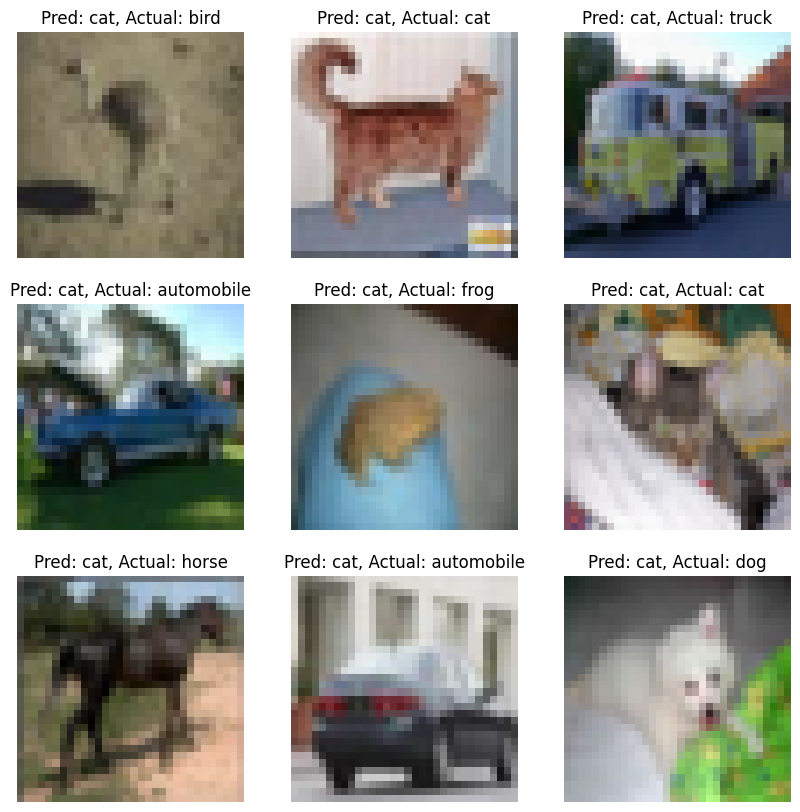

In [54]:
random_predictions(model3)

In [55]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model3.parameters(),lr=0.05)
train_test_loop(model3, train_dataloader, test_dataloader, 20, loss_fn, optimizer)

Epoch: 1/20
Train loss: 2.25975 | Test loss: 2.14293 Test accuracy: 20.54%
Epoch: 2/20
Train loss: 2.05873 | Test loss: 1.79701 Test accuracy: 35.85%
Epoch: 3/20
Train loss: 1.93841 | Test loss: 1.84896 Test accuracy: 35.83%
Epoch: 4/20
Train loss: 1.84214 | Test loss: 1.52072 Test accuracy: 45.68%
Epoch: 5/20
Train loss: 1.75602 | Test loss: 1.45417 Test accuracy: 47.72%
Epoch: 6/20
Train loss: 1.67227 | Test loss: 1.53255 Test accuracy: 44.95%
Epoch: 7/20
Train loss: 1.58977 | Test loss: 1.46416 Test accuracy: 46.42%
Epoch: 8/20
Train loss: 1.53250 | Test loss: 1.29099 Test accuracy: 54.38%
Epoch: 9/20
Train loss: 1.47077 | Test loss: 1.22729 Test accuracy: 57.46%
Epoch: 10/20
Train loss: 1.41131 | Test loss: 1.16789 Test accuracy: 58.75%
Epoch: 11/20
Train loss: 1.36224 | Test loss: 1.21188 Test accuracy: 58.52%
Epoch: 12/20
Train loss: 1.31460 | Test loss: 1.16154 Test accuracy: 59.51%
Epoch: 13/20
Train loss: 1.26963 | Test loss: 1.12695 Test accuracy: 60.50%
Epoch: 14/20
Train lo

In [56]:
train_test_loop(model3, train_dataloader, test_dataloader, 10, loss_fn, optimizer)

Epoch: 1/10
Train loss: 0.99000 | Test loss: 1.21483 Test accuracy: 61.35%
Epoch: 2/10
Train loss: 0.97425 | Test loss: 1.16203 Test accuracy: 62.59%
Epoch: 3/10
Train loss: 0.95171 | Test loss: 1.20436 Test accuracy: 62.37%
Epoch: 4/10
Train loss: 0.92320 | Test loss: 1.15950 Test accuracy: 64.26%
Epoch: 5/10
Train loss: 0.90944 | Test loss: 1.21941 Test accuracy: 62.99%
Epoch: 6/10
Train loss: 0.88924 | Test loss: 1.17982 Test accuracy: 64.01%
Epoch: 7/10
Train loss: 0.87401 | Test loss: 1.19286 Test accuracy: 63.24%
Epoch: 8/10
Train loss: 0.87027 | Test loss: 1.15681 Test accuracy: 63.69%
Epoch: 9/10
Train loss: 0.85331 | Test loss: 1.17981 Test accuracy: 64.09%
Epoch: 10/10
Train loss: 0.84365 | Test loss: 1.14414 Test accuracy: 64.70%


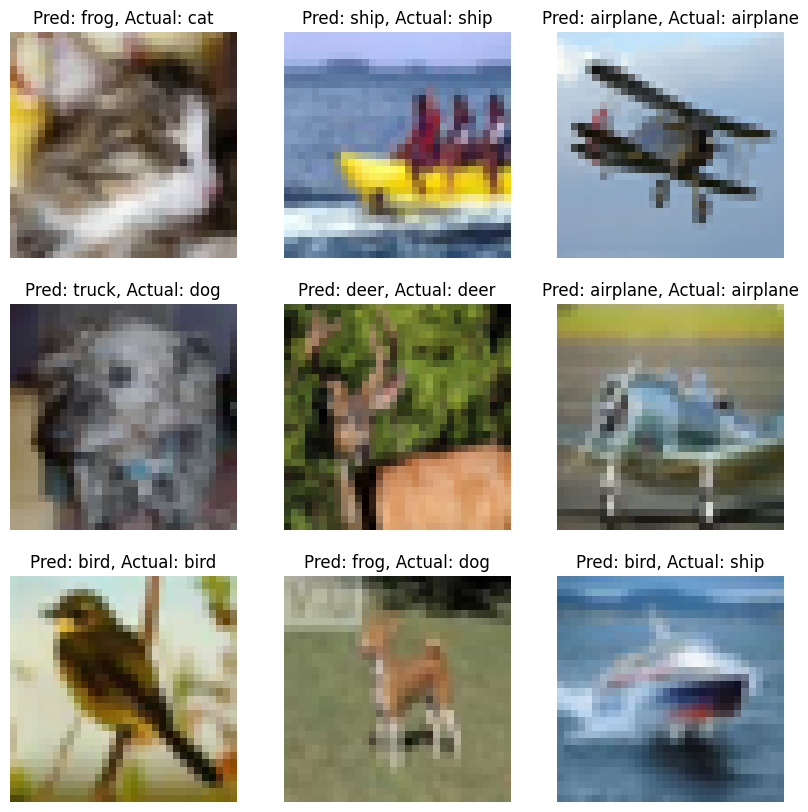

In [57]:
random_predictions(model3)